In [1]:
%matplotlib inline


# Visualizing the stock market structure


This example employs several unsupervised learning techniques to extract
the stock market structure from variations in historical quotes.

The quantity that we use is the daily variation in quote price: quotes
that are linked tend to cofluctuate during a day.


Learning a graph structure
--------------------------

We use sparse inverse covariance estimation to find which quotes are
correlated conditionally on the others. Specifically, sparse inverse
covariance gives us a graph, that is a list of connection. For each
symbol, the symbols that it is connected too are those useful to explain
its fluctuations.

Clustering
----------

We use clustering to group together quotes that behave similarly. Here,
amongst the `various clustering techniques <clustering>` available
in the scikit-learn, we use `affinity_propagation` as it does
not enforce equal-size clusters, and it can choose automatically the
number of clusters from the data.

Note that this gives us a different indication than the graph, as the
graph reflects conditional relations between variables, while the
clustering reflects marginal properties: variables clustered together can
be considered as having a similar impact at the level of the full stock
market.

Embedding in 2D space
---------------------

For visualization purposes, we need to lay out the different symbols on a
2D canvas. For this we use `manifold` techniques to retrieve 2D
embedding.


Visualization
-------------

The output of the 3 models are combined in a 2D graph where nodes
represents the stocks and edges the:

- cluster labels are used to define the color of the nodes
- the sparse covariance model is used to display the strength of the edges
- the 2D embedding is used to position the nodes in the plan

This example has a fair amount of visualization-related code, as
visualization is crucial here to display the graph. One of the challenge
is to position the labels minimizing overlap. For this we use an
heuristic based on the direction of the nearest neighbor along each
axis.


In [2]:
# Author: reddy prasade reddyprasade@gmail.com
# License: BSD 3 clause

import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import pandas as pd

from sklearn import cluster, covariance, manifold

# #############################################################################
#### Retrieve the data from Internet

* The data is from 2003 - 2008. This is reasonably calm: (not too long ago so
*  that we get high-tech firms, and before the 2008 crash). This kind of
* historical data can be obtained for from APIs like the quandl.com and alphavantage.co ones.

In [3]:
symbol_dict = {
    'TOT': 'Total',
    'XOM': 'Exxon',
    'CVX': 'Chevron',
    'COP': 'ConocoPhillips',
    'VLO': 'Valero Energy',
    'MSFT': 'Microsoft',
    'IBM': 'IBM',
    'TWX': 'Time Warner',
    'CMCSA': 'Comcast',
    'CVC': 'Cablevision',
    'YHOO': 'Yahoo',
    'DELL': 'Dell',
    'HPQ': 'HP',
    'AMZN': 'Amazon',
    'TM': 'Toyota',
    'CAJ': 'Canon',
    'SNE': 'Sony',
    'F': 'Ford',
    'HMC': 'Honda',
    'NAV': 'Navistar',
    'NOC': 'Northrop Grumman',
    'BA': 'Boeing',
    'KO': 'Coca Cola',
    'MMM': '3M',
    'MCD': 'McDonald\'s',
    'PEP': 'Pepsi',
    'K': 'Kellogg',
    'UN': 'Unilever',
    'MAR': 'Marriott',
    'PG': 'Procter Gamble',
    'CL': 'Colgate-Palmolive',
    'GE': 'General Electrics',
    'WFC': 'Wells Fargo',
    'JPM': 'JPMorgan Chase',
    'AIG': 'AIG',
    'AXP': 'American express',
    'BAC': 'Bank of America',
    'GS': 'Goldman Sachs',
    'AAPL': 'Apple',
    'SAP': 'SAP',
    'CSCO': 'Cisco',
    'TXN': 'Texas Instruments',
    'XRX': 'Xerox',
    'WMT': 'Wal-Mart',
    'HD': 'Home Depot',
    'GSK': 'GlaxoSmithKline',
    'PFE': 'Pfizer',
    'SNY': 'Sanofi-Aventis',
    'NVS': 'Novartis',
    'KMB': 'Kimberly-Clark',
    'R': 'Ryder',
    'GD': 'General Dynamics',
    'RTN': 'Raytheon',
    'CVS': 'CVS',
    'CAT': 'Caterpillar',
    'DD': 'DuPont de Nemours'}


symbols, names = np.array(sorted(symbol_dict.items())).T

In [4]:
quotes = []

for symbol in symbols:
    print('Fetching quote history for %r' % symbol, file=sys.stderr)
    url = ('https://raw.githubusercontent.com/reddyprasade/Machine-Learning-Problems-DataSets/master/Clustering/financial-data/{}.csv')
    quotes.append(pd.read_csv(url.format(symbol)))

Fetching quote history for 'AAPL'
Fetching quote history for 'AIG'
Fetching quote history for 'AMZN'
Fetching quote history for 'AXP'
Fetching quote history for 'BA'
Fetching quote history for 'BAC'
Fetching quote history for 'CAJ'
Fetching quote history for 'CAT'
Fetching quote history for 'CL'
Fetching quote history for 'CMCSA'
Fetching quote history for 'COP'
Fetching quote history for 'CSCO'
Fetching quote history for 'CVC'
Fetching quote history for 'CVS'
Fetching quote history for 'CVX'
Fetching quote history for 'DD'
Fetching quote history for 'DELL'
Fetching quote history for 'F'
Fetching quote history for 'GD'
Fetching quote history for 'GE'
Fetching quote history for 'GS'
Fetching quote history for 'GSK'
Fetching quote history for 'HD'
Fetching quote history for 'HMC'
Fetching quote history for 'HPQ'
Fetching quote history for 'IBM'
Fetching quote history for 'JPM'
Fetching quote history for 'K'
Fetching quote history for 'KMB'
Fetching quote history for 'KO'
Fetching quote h

In [5]:
close_prices  = np.vstack([q['close'] for q in quotes])
# print(close_prices)

open_prices  = np.vstack([q['open'] for q in quotes])
#print(open_prices)

In [6]:
# The daily variations of the quotes are what carry most information
variations = close_prices - open_prices

In [7]:
print(variations)

[[ 0.44  0.1  -0.13 ... -0.38 -0.76 -1.42]
 [ 2.2   0.07  2.02 ... -1.08 -0.32  0.93]
 [ 0.38  0.93  0.3  ...  1.58 -0.82 -1.17]
 ...
 [ 0.47  0.25  0.93 ... -1.27  0.74 -0.7 ]
 [ 0.07  0.12  0.21 ... -0.14  0.13 -0.13]
 [ 1.01  0.6   1.09 ...  0.11 -0.21  0.04]]


In [8]:
# Learn a graphical structure from the correlations

edge_model  = covariance.GraphicalLassoCV()

In [9]:
# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = variations.copy().T
X /= X.std(axis=0)

In [10]:
edge_model.fit(X)

GraphicalLassoCV()

In [11]:
# Cluster using affinity propagation

_, labels = cluster.affinity_propagation(edge_model.covariance_,
                                         random_state=0)

n_labels = labels.max()

In [12]:
print(n_labels)

10


In [13]:
for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

Cluster 1: Apple, Amazon, Yahoo
Cluster 2: Comcast, Cablevision, Time Warner
Cluster 3: ConocoPhillips, Chevron, Total, Valero Energy, Exxon
Cluster 4: Cisco, Dell, HP, IBM, Microsoft, SAP, Texas Instruments
Cluster 5: Boeing, General Dynamics, Northrop Grumman, Raytheon
Cluster 6: AIG, American express, Bank of America, Caterpillar, CVS, DuPont de Nemours, Ford, General Electrics, Goldman Sachs, Home Depot, JPMorgan Chase, Marriott, 3M, Ryder, Wells Fargo, Wal-Mart
Cluster 7: McDonald's
Cluster 8: GlaxoSmithKline, Novartis, Pfizer, Sanofi-Aventis, Unilever
Cluster 9: Kellogg, Coca Cola, Pepsi
Cluster 10: Colgate-Palmolive, Kimberly-Clark, Procter Gamble
Cluster 11: Canon, Honda, Navistar, Sony, Toyota, Xerox


* We have to find the low-dimension for visualizations  for find the best positions of names of Company 2D planes (The Stock )
* we have use dense eigen_slover initiated with random vectors that we don't control). In addition, we
* use a large number of neighbors to capture the large-scale structure.

In [14]:
node_position_model = manifold.LocallyLinearEmbedding(n_components=2,
                                                     eigen_solver='dense',
                                                     n_neighbors=6)

In [15]:
embedding = node_position_model.fit_transform(X.T).T

In [16]:
embedding[0]

array([-0.03133457, -0.10085752, -0.03196732, -0.08565947,  0.00867911,
       -0.10968898,  0.023698  , -0.03050856, -0.09036982, -0.0979985 ,
        0.40342683, -0.06535529, -0.09821818, -0.0781259 ,  0.37519749,
       -0.06055747, -0.06049054, -0.05551777, -0.02190345, -0.10630194,
       -0.05105478,  0.12884665, -0.07331181,  0.09111769, -0.06057465,
       -0.07096079, -0.09648828, -0.08914968, -0.09164275, -0.04852844,
       -0.06430036, -0.06559589, -0.07657756, -0.09177229, -0.02456882,
        0.01952134,  0.16918205, -0.0856531 , -0.00188195, -0.09252651,
       -0.03204468, -0.00692426, -0.02722191,  0.01286955,  0.15994247,
        0.04671119,  0.33992381, -0.09725258, -0.03543681,  0.16549804,
        0.35953018, -0.10711761, -0.09375813,  0.36123698, -0.01145603,
       -0.04472645])

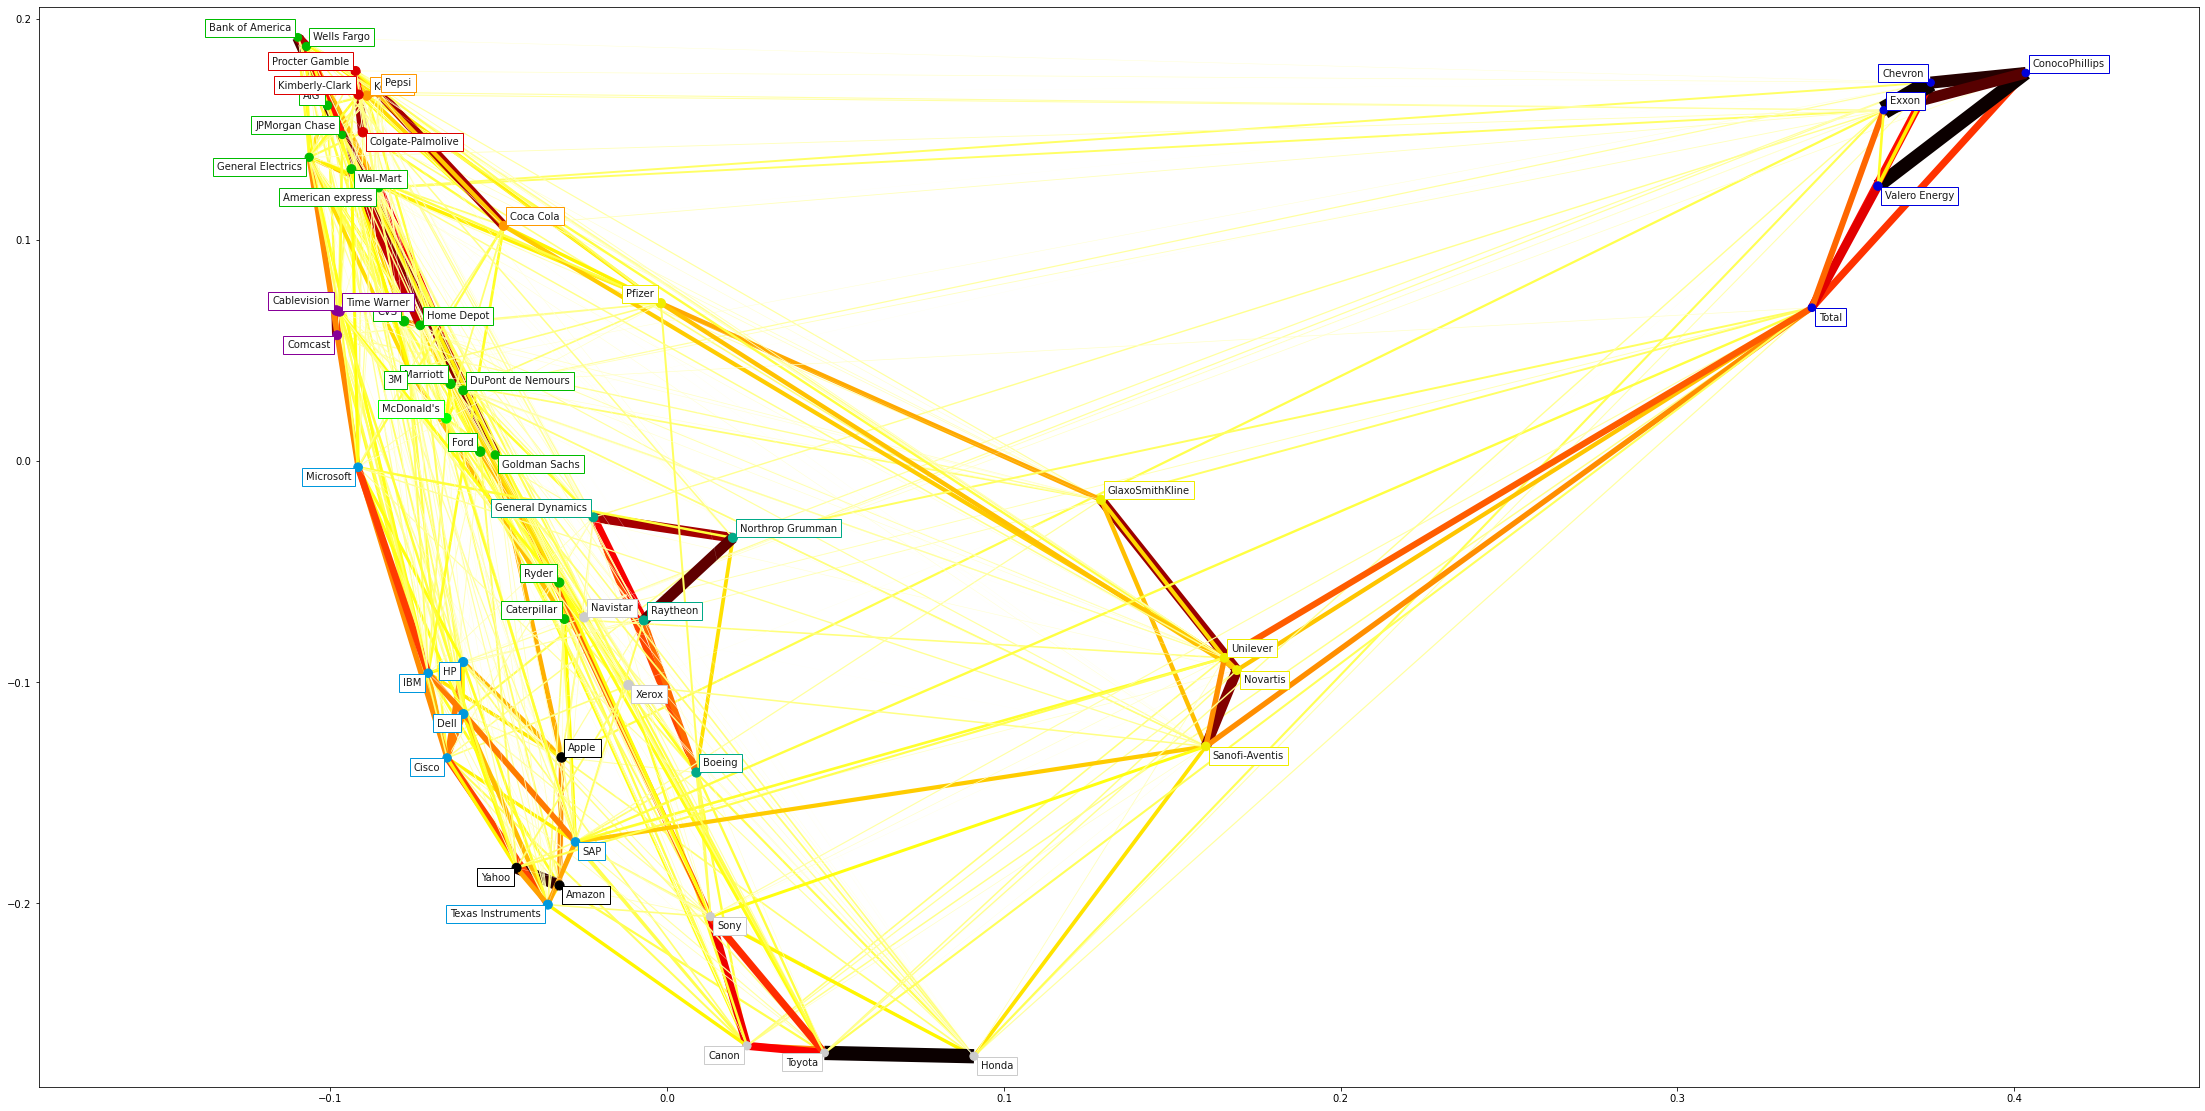

In [17]:
plt.figure(1, facecolor='w', figsize=(30, 15))
plt.clf()
ax = plt.axes([0.,0.,1.,1.])
#plt.axes('off')


# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()

d = 1/ np.sqrt(np.diag(partial_correlations))

partial_correlations *=d
partial_correlations *=d[:,np.newaxis]

non_zero = (np.abs(np.triu(partial_correlations, k=1))>0.002)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels, cmap=plt.cm.nipy_spectral)

# plot the edges 
start_idx, end_idx = np.where(non_zero)

segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]

values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(50 * values)
ax.add_collection(lc)


# we  have to add labels foe each and every node the data, we have challenge hear is that which position of the data point below to which Company 

for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):
    
    dx = x - embedding[0]
    dx[index] = 1
    dy = y- embedding[1]
    dy[index]=1
    
    this_dx= dx[np.argmin(np.abs(dy))]
    this_dy= dy[np.argmin(np.abs(dx))]
    
    
    if this_dx > 0 :
        horizontalalignment  = 'left'
        x = x + 0.002
    else:
        horizontalalignment  = 'right'
        x = x - 0.002
    
    if this_dy > 0 :
        verticalalignment   = 'bottom'
        y = y + 0.002
    else:
        verticalalignment  = 'top'
        y = y - 0.002
        
    
    plt.text(x,y,name, size=10,
            horizontalalignment= horizontalalignment,
            verticalalignment=verticalalignment,
            bbox = dict(facecolor = 'w',
                       edgecolor= plt.cm.nipy_spectral(label/float(n_labels))),
            alpha=.9)


plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.savefig("affinity_propagation_for_stock_market.png",dip=300)
plt.show()       